# Proyecto final Curso UDACITY
## En este notebook, procedo a realizar la última práctica del curso de deep learning de Udacity


Lo primero que procedemos a realizar es cargar todas las librerías que se utilizarán.

In [29]:
#Importamos todas las librerias correspondientes a nuestro trabajo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf

## Importante! cargar los dataset de esta actividad
Para poder realizar esta actividad, es necesario cargar los siguientes datasets, por restricciones de espacio utilizando en el disco de los datasets, no puedo subir el archivo al repositorio en github.  
Los links de los datasets, son los siguientes:

+ http://ufldl.stanford.edu/housenumbers/test_32x32.mat
+ http://ufldl.stanford.edu/housenumbers/train_32x32.mat  
Para el correcto funcionamiento, estos datasets deben estar dentro del directorio del curso, dentro del taller 6 como se muestra a continuación:  
<img src="Ejemplo.png">

## En esta celda procedemos a crear una función que se encarga de cargarnos todos los datos de los datasets a nuestras variables en python.

In [42]:
def cargarDataSets(train_file,test_file):
    train_file_map = scipy.io.loadmat(train_file)
    test_file_map = scipy.io.loadmat(test_file)
    train_data = train_file_map['X']
    train_labels = np.array(train_file_map['y'])
    train_labels = train_labels.reshape(len(train_labels))
    test_labels = test_file_map['y']
    test_labels = test_labels.reshape((len(test_labels)))
    mitad = int(len(test_labels)/2)
    valid_labels = test_labels[mitad:]
    test_labels = test_labels[:mitad]
    test_data = test_file_map['X']
    valid_data = test_data[:,:,:,mitad:]
    test_data = test_data [:,:,:,:mitad]
    train_data_set = ( train_data[:,:,0,:] + train_data[:,:,1,:]+ train_data[:,:,2,:] )/3
    test_data_set = ( test_data[:,:,0,:] + test_data[:,:,1,:] + test_data[:,:,2,:] )/3
    valid_data_set = ( valid_data[:,:,0,:] + valid_data[:,:,1,:] + valid_data[:,:,2,:] )/3
    return train_data_set,train_labels,test_data_set,test_labels,valid_data_set,valid_labels

## Cargamos las funciones de nuestra actividad
En estas celdas nos encargamos de definir algunos parámetros básicos como lo son:
+ Cantidad de filas y columnas de nuestras imagenes (32 porque nuestro dataset posee matrices cuadradas de dicho tamaño)
+ Cantidad de clases (11 porque existen imágenes del 0 al 10) 
+ Cantidad de canales (1, ya que procesamos las imagenes del dataset para obtener sólo un canal a escala de grises)  
También procedemos a cargar las funciones de nuestra actividad.

In [31]:
image_size = 32
num_labels = 11
num_channels = 1

def reformatLabels(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]\n",
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels

def reformatDataSet(dataSet):
    nuevoDataSet = dataSet.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    for i in range (len(nuevoDataSet)):
        nuevoDataSet[i,:,:,0] = nuevoDataSet[i,:,:,0].T
    return nuevoDataSet

def normalizarDataSet(dataSet):
    return (dataSet/128) - 0.5

def comprobarIntegridadEntrenamiento(train_data,train_labels):
    aleatorio = np.random.randint(0,len(train_labels))
    imagen = train_data[aleatorio,:,:,0]
    print("Prueba de integridad en el data set de Entrenamiento")
    plt.imshow(imagen , cmap = 'gray')
    print ("La clase de esta imagen es :",np.argmax(train_labels[aleatorio]))
    
def comprobarIntegridadTest(test_data,test_labels):
    aleatorio = np.random.randint(0,len(test_labels))
    imagen = test_data[aleatorio,:,:,0]
    print("Prueba de integridad en el data set de Test")
    plt.imshow(imagen , cmap = 'gray')
    print ("La clase de esta imagen es :",np.argmax(test_labels[aleatorio]))

def comprobarIntegridadValid(valid_data,valid_labels):
    aleatorio = np.random.randint(0,len(valid_labels))
    imagen = valid_data[aleatorio,:,:,0]
    print("Prueba de integridad en el data set de validación")
    plt.imshow(imagen , cmap = 'gray')
    print ("La clase de esta imagen es :",np.argmax(valid_labels[aleatorio]))

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

In [32]:
num_channels = 1
image_size = 32
train_file = 'train_32x32.mat'
test_file = 'test_32x32.mat'
train_data,train_labels,test_data,test_labels,valid_data,valid_labels = cargarDataSets(train_file,test_file)
train_data = reformatDataSet(normalizarDataSet(train_data.T))
train_labels = reformatLabels(train_labels)
test_data = reformatDataSet(normalizarDataSet(test_data.T))
test_labels = reformatLabels(test_labels)
valid_labels = reformatLabels(valid_labels)
valid_data = reformatDataSet(normalizarDataSet(valid_data.T))

# Comprobamos la integridad de nuestro dataset luego de cargar los datos
En las siguientes tres celdas nos enfocaremos en mostrar una imagen aleatória de cada uno de los datasets y expondremos la clase del mismo, esto para hacer un check visual y manual de la data con la que estamos trabajando.

Prueba de integridad en el data set de Entrenamiento
La clase de esta imagen es : 4


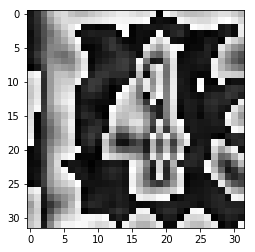

In [33]:
comprobarIntegridadEntrenamiento(train_data,train_labels)


Prueba de integridad en el data set de Test
La clase de esta imagen es : 1


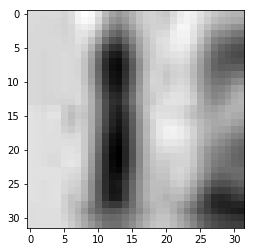

In [49]:
comprobarIntegridadTest(test_data,test_labels)

Prueba de integridad en el data set de validación
La clase de esta imagen es : 3


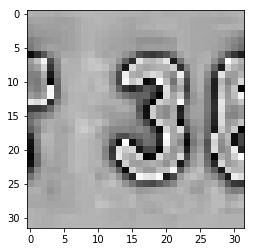

In [50]:
comprobarIntegridadValid(valid_data,valid_labels)

## Red Neuronal Convolucional (CNN)
  
Para dar solución a esta actividad, he propuesto una red neuronal con los siguientes parámetros:
+ batch_size = 64
+ patch_size = 5
+ depth = 32
+ num_hidden = 64
+ num_channels = 1
+ keep_prob = 0.85
+ Beta = 0.0001  
En las siguientes dos celdas se muestra el código fuente en tensorflow de la red neuronal convolucional con los parámetros mencionados, la primera celda es la lógica detrás de la red neuronal, y la segunda celda hace referencia a la ejecución de dicha red neuronal.


In [47]:
#Red neuronal convolucional

#valores de prueba#
batch_size = 64
patch_size = 5
depth = 32
num_hidden = 64
num_channels = 1
keep_prob = 0.85
Beta = 0.0001
graph = tf.Graph()
#---------------#

with graph.as_default():

    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset =  tf.to_float( tf.constant(valid_data) )
    tf_test_dataset = tf.to_float( tf.constant(test_data) )
    
    # Variables.
    layer1_weights = tf.to_float( tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1)) )
    layer1_biases = tf.to_float( tf.Variable(tf.zeros([depth])) )
    layer2_weights = tf.to_float( tf.Variable(tf.truncated_normal(
    [patch_size, patch_size, depth, depth], stddev=0.1)) )
    layer2_biases = tf.to_float( tf.Variable(tf.constant(1.0, shape=[depth])) )
    layer3_weights = tf.to_float ( tf.Variable(tf.truncated_normal(
    [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1)) )
    layer3_biases = tf.to_float ( tf.Variable(tf.constant(1.0, shape=[num_hidden])) )
    layer4_weights = tf.to_float( tf.Variable(tf.truncated_normal(
    [num_hidden, num_labels], stddev=0.1)))
    layer4_biases = tf.to_float( tf.Variable(tf.constant(1.0, shape=[num_labels])) )

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        conv = tf.nn.max_pool(value=conv , ksize=[1,2,2,1] , strides= [1,2,2,1] ,padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.dropout( hidden, keep_prob )
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        conv = tf.nn.max_pool(value=conv , ksize=[1,2,2,1] , strides= [1,2,2,1] ,padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.dropout( hidden, keep_prob )
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.\n",
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    loss = tf.reduce_mean( loss + Beta*(tf.nn.l2_loss(layer1_weights)+
                                         tf.nn.l2_loss(layer2_weights)+ tf.nn.l2_loss(layer3_weights)+
                                         tf.nn.l2_loss(layer4_weights)))

    # Optimizer
    optimizer = tf.train.AdagradOptimizer(0.08).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [48]:
num_steps = 5001
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.645894
Minibatch accuracy: 12.5%
Validation accuracy: 6.6%
Minibatch loss at step 100: 2.296008
Minibatch accuracy: 20.3%
Validation accuracy: 19.7%
Minibatch loss at step 200: 2.230677
Minibatch accuracy: 17.2%
Validation accuracy: 16.7%
Minibatch loss at step 300: 2.349463
Minibatch accuracy: 15.6%
Validation accuracy: 19.7%
Minibatch loss at step 400: 2.349088
Minibatch accuracy: 18.8%
Validation accuracy: 19.8%
Minibatch loss at step 500: 2.258370
Minibatch accuracy: 26.6%
Validation accuracy: 20.4%
Minibatch loss at step 600: 2.229650
Minibatch accuracy: 23.4%
Validation accuracy: 20.2%
Minibatch loss at step 700: 2.209282
Minibatch accuracy: 28.1%
Validation accuracy: 20.6%
Minibatch loss at step 800: 2.276118
Minibatch accuracy: 15.6%
Validation accuracy: 23.3%
Minibatch loss at step 900: 2.182385
Minibatch accuracy: 26.6%
Validation accuracy: 28.8%
Minibatch loss at step 1000: 2.095731
Minibatch accuracy: 26.6%
Validation accuracy: 36.8%
